In [ ]:
from PIL import Image
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Conv2DTranspose, Add, Lambda, Flatten, Reshape
from keras.optimizers import Adam
from tensorflow.keras.layers import PReLU
from keras.regularizers import l2
import keras.backend as K
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import heapq
import collections
from typing import List, Dict, Tuple

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Resize, conversion and normalisation des photos


Fonction de resize, normalisation, conversion en nuances de gris


In [ ]:
def resize_and_convert_to_gray(input_path, size=(128, 128)):
    with Image.open(input_path) as img:
        img = img.resize(size)
        gray_img = img.convert('L')
        gray_img.save("Image_grise_1.png")
        img_array = np.asarray(gray_img, dtype=np.float32) / 255.0
        return img_array.reshape(size[0], size[1], 1)

In [ ]:
def convert_to_gray_and_save(img_array, output_path):

    img_array *= 255.0
    img_array = img_array.clip(0, 255)
    img_gray = Image.fromarray(np.uint8(img_array), 'L')
    img_gray.save(output_path)

    return img_gray


## Autoencoder

Définition de l'autoencoder => 6 convolutional layers

In [ ]:
def encoder(input_shape):
    input_layer = Input(shape=input_shape)
    # 1er Conv2D
    x = Conv2D(32, (3, 3), strides=1, padding='same')(input_layer)
    x = PReLU()(x)
    # 2eme Conv2D
    x = Conv2D(32, (3, 3), strides=2, padding='same')(x)
    x = PReLU()(x)
    # 3eme Conv2D
    x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
    x = PReLU()(x)
    # 4eme Conv2D
    x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = PReLU()(x)
    # 5eme Conv2D
    x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
    x = PReLU()(x)
    # 6eme Conv2D
    x = Conv2D(32, (3, 3), strides=2, padding='same')(x)
    x = PReLU()(x)
    # Ajout de bruit uniforme
    noise = Lambda(lambda x: x + K.random_uniform(K.shape(x), -1/(2**10), 1/(2**10)))(x)
    return Model(input_layer, noise)

Définition du decoder => 6 convolutional layers miroirs de l'encoder

In [ ]:
def decoder(encoded_shape):
    encoded_input = Input(shape=encoded_shape)
    # Miroir du 6eme Conv2D
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(encoded_input)
    x = PReLU()(x)
    # Miroir du 5eme Conv2D
    x = Conv2DTranspose(64, (3, 3), strides=1, padding='same')(x)
    x = PReLU()(x)
    # Miroir du 4eme Conv2D
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = PReLU()(x)
    # Miroir du 3eme Conv2D
    x = Conv2DTranspose(64, (3, 3), strides=1, padding='same')(x)
    x = PReLU()(x)
    # Miroir du 2eme Conv2D
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = PReLU()(x)
    # Miroir du 1er Conv2D
    x = Conv2DTranspose(1, (3, 3), strides=1, padding='same')(x)
    x = PReLU()(x)
    return Model(encoded_input, x)

Loss function custom


In [ ]:
def custom_loss(encoded_layer, lambda_val=1.0):
    def loss(y_true, y_pred):
        mse = K.mean(K.square(y_true - y_pred))
        l2_penalty = lambda_val * K.mean(K.square(encoded_layer))
        return mse + l2_penalty
    return loss


Création de l'autoencoder à partir de l'encoder et du decoder

In [ ]:
input_shape = (128, 128, 1)  # Supposons des images RGB 128x128

# Créer l'encoder
enc = encoder(input_shape)
encoded_shape = enc.output_shape[1:]

# Créer le decoder
dec = decoder(encoded_shape)

# Connecter l'encoder et le decoder pour former l'autoencoder
input_layer = Input(shape=input_shape)
encoded_output = enc(input_layer)
decoded_output = dec(encoded_output)

autoencoder = Model(input_layer, decoded_output)

optimizer = Adam(learning_rate=0.0001)

autoencoder.compile(optimizer=optimizer, loss='mse')

In [ ]:
#autoencoder = load_model("autoencoder_model50000.keras", safe_mode=False)


Résumé de l'autoencoder

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 model (Functional)          (None, 16, 16, 32)        1177152   
                                                                 
 model_1 (Functional)        (None, 128, 128, 1)       1283617   
                                                                 
Total params: 2460769 (9.39 MB)
Trainable params: 2460769 (9.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Création des dataset de train et de test. 80-20%

In [ ]:
image_files = glob.glob('Kodak/*.png')
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

Entrainement et sauvegarde du modèle

In [ ]:
# Charger et préparer les images
train_images = np.array([resize_and_convert_to_gray(path) for path in train_files])
test_images = np.array([resize_and_convert_to_gray(path) for path in test_files])

# Entraîner l'autoencoder
autoencoder.fit(train_images, train_images, epochs=5000, batch_size=16, validation_data=(test_images, test_images))
autoencoder.save('autoencoder_model50000.keras')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 45ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2502/5000
2/2 [==============================] - 0s 49ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2503/5000
2/2 [==============================] - 0s 48ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2504/5000
2/2 [==============================] - 0s 47ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2505/5000
2/2 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2506/5000
2/2 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2507/5000
2/2 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2508/5000
2/2 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2509/5000
2/2 [==============================] - 0s 47ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 2510/5000
2/2 

## Test de reconstruction d'images pour le test

In [ ]:
image = resize_and_convert_to_gray('Kodak/kodim12.png')
image= np.expand_dims(image, axis=0)
reconstructed_images = autoencoder.predict(image)
output_folder = 'compressed_images/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i, img_array in enumerate(reconstructed_images):
    img = Image.fromarray((img_array.squeeze() * 255).astype(np.uint8))
    img.save(os.path.join(output_folder, f'image_compressee_{i+1:02d}.png'))


1/1 [==============================] - 1s 649ms/step


## Fonctions

In [ ]:
def encoding(image_path, enc):
  image = resize_and_convert_to_gray(image_path)
  image = np.expand_dims(image, axis=0)
  encoded_image = enc.predict(image)
  encoded_vector = encoded_image[0]
  return encoded_vector

In [ ]:
def resize_vector(y) :

  y_out = []
  vecteur_squeezed = np.squeeze(y)
  vecteurs_decoupes = np.split(vecteur_squeezed, vecteur_squeezed.shape[2], axis=2)
  for vecteur in vecteurs_decoupes :
    vecteur = np.squeeze(vecteur, axis =2)
    y_out.append(vecteur)

  return y_out

In [ ]:
def PCA(y):

    m = 32
    result = np.zeros_like(y[0])
    for features in y:
      result += np.dot(features.T, features)

    covariance_matrix = result/m

    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    U = eigenvectors[:, sorted_indices]

    y_rotated = []
    for features in y:

      y_rot = np.dot(U.T, features)
      y_rotated.append(y_rot)

    return y_rotated, U

In [ ]:
def Quantizer(y, B) :

  m = len(y)
  list = []
  for i in range(m):
    float_array = y[i]*2**(B-1)
    rounded_int_array = np.round(float_array).astype(int)
    list.append(rounded_int_array)

  return list

In [ ]:
def huffman_encoding(matrices: List[np.ndarray]) -> Tuple[Dict[int, str], List[List[str]]]:
    # Fusionner tous les éléments des matrices pour calculer la fréquence globale
    all_elements = [item for matrix in matrices for item in matrix.flatten()]
    frequency = collections.Counter(all_elements)

    # Construire un tas de priorité avec les fréquences
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)

    # Construire l'arbre de Huffman
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Générer les codes Huffman
    huffman_code = {symbol: code for symbol, code in heapq.heappop(heap)[1:]}

    # Encoder les matrices
    encoded_matrices = [[huffman_code[item] for item in matrix.flatten()] for matrix in matrices]

    return huffman_code, encoded_matrices

In [ ]:
def huffman_decoding(encoded_matrices: List[List[str]], huffman_code: Dict[int, str]) -> List[np.ndarray]:

    # Inverser le dictionnaire de codes Huffman pour le décodage
    code_huffman = {v: k for k, v in huffman_code.items()}

    # Décoder les matrices
    decoded_matrices = [np.array([code_huffman[code] for code in encoded_matrix]).reshape((16, 16)) for encoded_matrix in encoded_matrices]

    return decoded_matrices

In [ ]:
def Dequantizer(y, B):

    m = len(y)
    y_tilde = []
    for i in range(m):
        float_array = y[i] / (2**(B-1))
        float_array2 = float_array.astype(float)
        y_tilde.append(float_array2)

    return y_tilde

In [ ]:
def Inverse_Pca(y, U):
  return np.dot(y, U)

In [ ]:
def decoding(output_path,dec, y):
  encoded_vector_batch = np.expand_dims(y, axis=0)
  reconstructed_data = dec.predict(encoded_vector_batch)
  image_finale =  reconstructed_data[0]
  convert_to_gray_and_save(image_finale.squeeze(), output_path)


In [ ]:
def affiche_latent_vector (encoded_vector) :

  fig, axes = plt.subplots(4, 8, figsize=(20, 10))
  axes = axes.flatten()

  for i, ax in enumerate(axes):

      if i < encoded_vector.shape[-1]:
          ax.imshow(encoded_vector[:, :, i], cmap='gray')
          ax.set_title(f"Canal {i+1}")
          ax.axis('off')
      else:
          ax.axis('off')

  plt.tight_layout()
  plt.show()


In [ ]:
def affiche_yrot(y_rot) :

  fig, axes = plt.subplots(4, 8, figsize=(20, 10))
  axes = axes.flatten()

  for i, ax in enumerate(axes):

      if i < 32:
          ax.imshow(y_rot[i][:, :,], cmap='gray')
          ax.set_title(f"Canal {i+1}")
          ax.axis('off')
      else:
          ax.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def resize_vector_inverse(y):
    y_out = []
    for vecteur in y:
        vecteur_expanded = np.expand_dims(vecteur, axis=2)
        y_out.append(vecteur_expanded)
    y_concatenated = np.concatenate(y_out, axis=2)
    return y_concatenated

## Simulation

### Encodage

In [ ]:
encoded_vector = encoding('Kodak/kodim07.png', enc)
y_resize =  resize_vector(encoded_vector)
y_rot, U = PCA(y_resize)
y_quant = Quantizer(y_rot, 12)

1/1 [==============================] - 0s 378ms/step


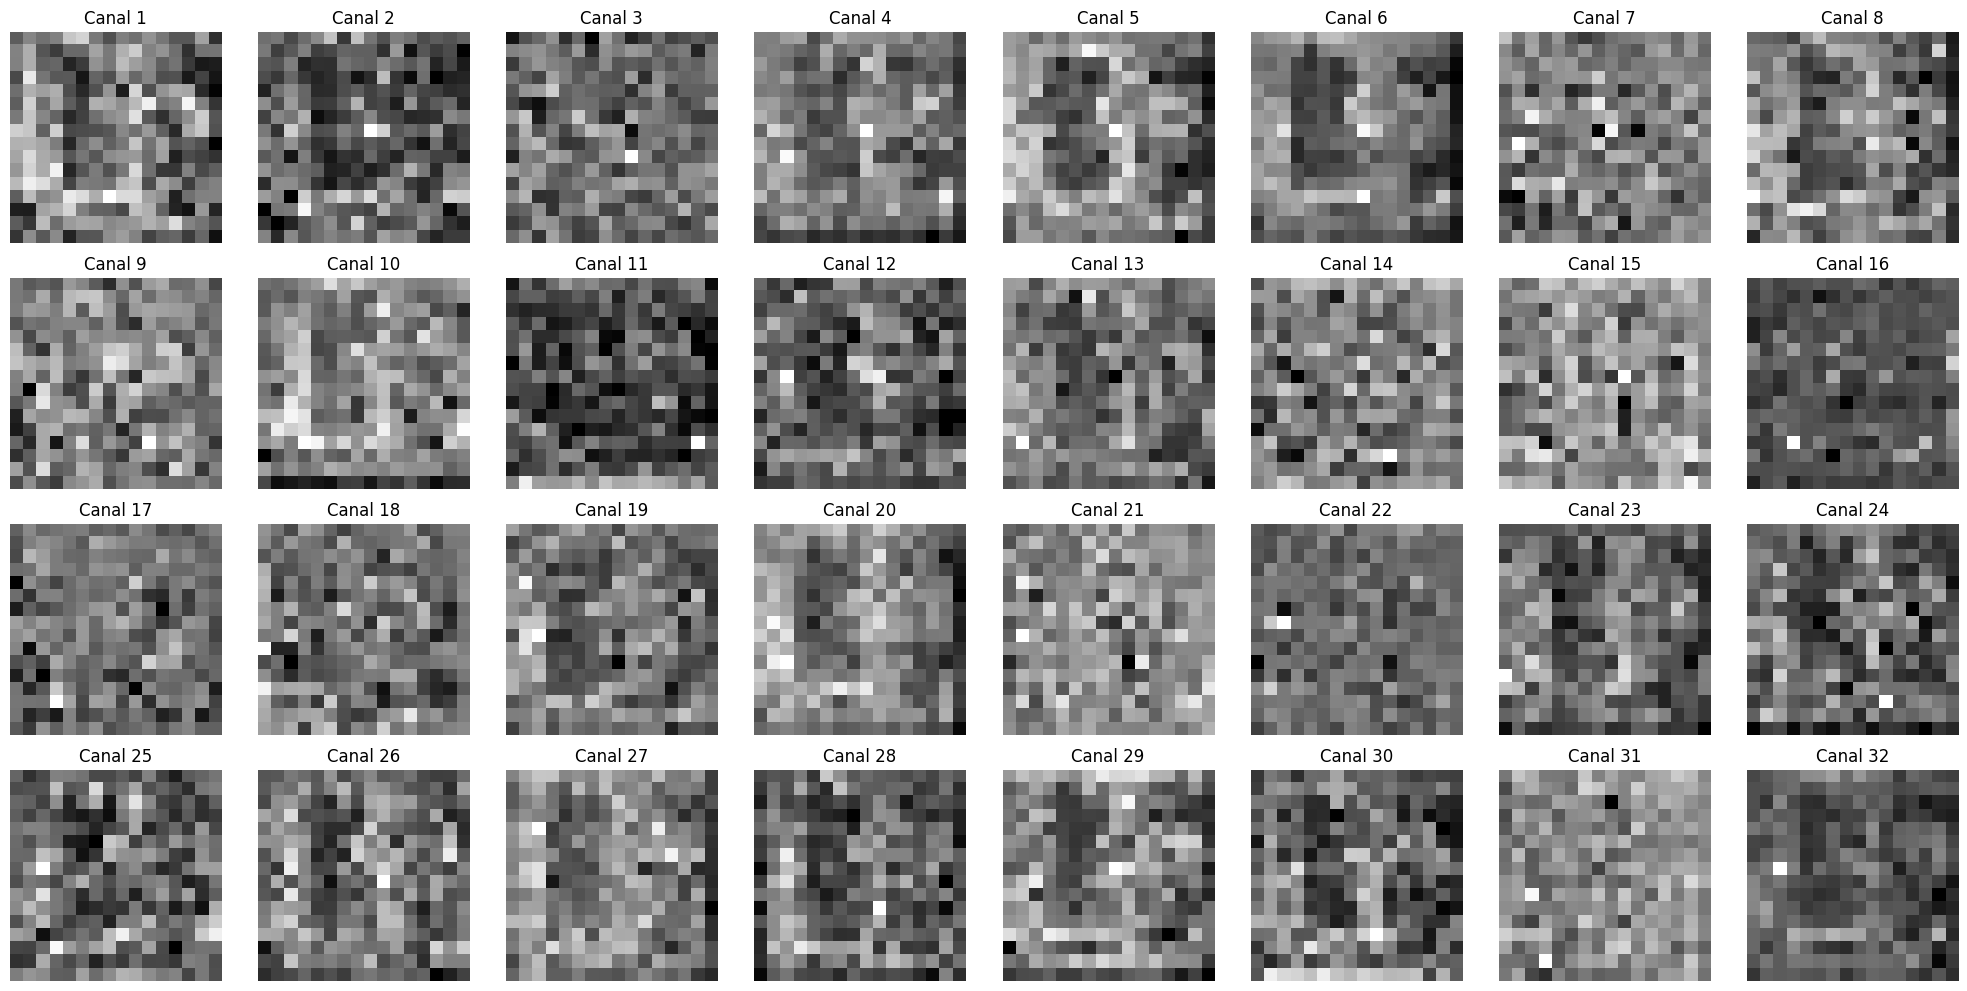

In [ ]:
affiche_latent_vector (encoded_vector)

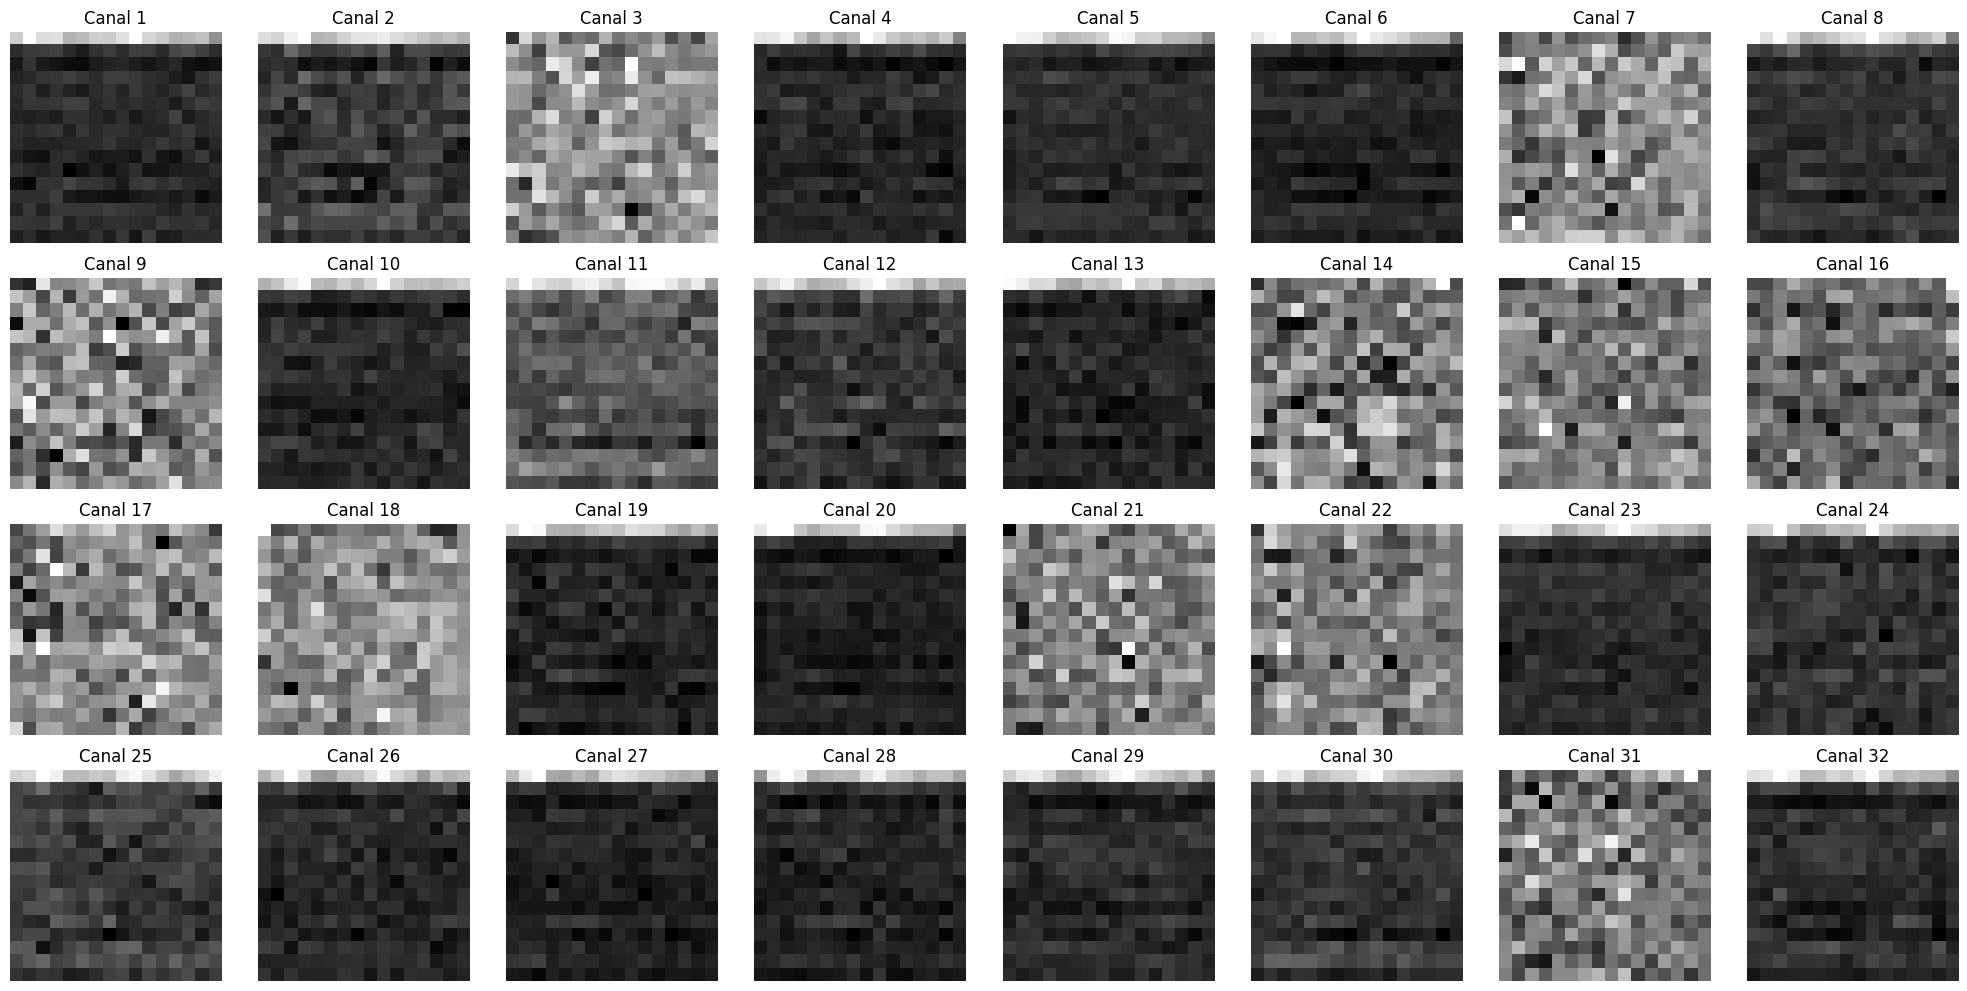

In [ ]:
affiche_yrot(y_rot)

## Entropy coding

In [ ]:
# Encoder les matrices
huffman_code, encoded_matrices = huffman_encoding(y_quant)

# Décoder les matrices
decoded_matrices = huffman_decoding(encoded_matrices, huffman_code)

Calcul Taille vecteur

In [ ]:
# Calculer le nombre total de bits
total_bits = sum(len(bitstring) for bitsequence in encoded_vector for bitstring in bitsequence)

# Convertir en octets
total_bytes = total_bits / 8

print(total_bytes)


1024.0


### Decodage

In [ ]:
y_dequant = Dequantizer(decoded_matrices, 12)
y_inverse_pca = Inverse_Pca(y_dequant,U)
y_final = resize_vector_inverse(y_inverse_pca)
decoding("image_test.png",dec, y_final)

1/1 [==============================] - 0s 355ms/step
